<a href="https://colab.research.google.com/github/zjay1995/Computational_Robotics/blob/master/pset4/pset4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EE209AS Pset4: RRT Algorithm
by Zhijie Wang 304946569

##Preliminaries
*   0(a). Link to my github repo: https://github.com/zjay1995/Computational_Robotics/blob/master/RRT/pset4.ipynb
*   0(b). Individual
*   0(c). Reference:
PythonRobotics by Atsushi Sakai
*   0(d). Myself
*   0(e). 100%

## Problem Statement

Here we considered the 2 wheeled robot from lab 3, this time ignoring sensors and noise terms. For simplicity,
we considered the robot to be a circle of diameter 115mm. For realism, we optionally considered the true shape
of the robot to be a rectangle of length 80mm and width 85mm; the center of the axle is 10mm from the front of the
robot 

The robot must move through a cluttered 2D rectangular environment representing a parking lot. You will want to
consider geometric obstacles defined by rectangles specified within the space. For additional complexity, you may
want to include ”one-way” regions in the space that only permit motion in one direction (with motion in the other
directions represented by obstacles in C-space).
The robot must achieve a prescribed goal, i.e. a desired x, y, θ.

**Each sections below are the building block towards RRT algorithm:**

**2(a). Given a set of points V in C-space and a single other target point, determine which of the points in V is
closest to the target.**

Compare the distance of target and every node and find the minimum one.

In [0]:
import numpy as np
import math
import sys
import matplotlib.pyplot as plt
from numpy import cos,sin
from scipy.spatial import ConvexHull

# Robot parameters
r = 20.0 #mm
w = 85.0 #mm
R = 115.0 #mm

class node:
    """
    Build a class of node
    """
    def __init__(self,state):
        self.state = state
        self.parent = None

def find_nearest_node(V, target):
  """
  Input:
  V = list of nodes
  target = the node that we are comparing to
  
  Output:
  nearest_node = the state of nearest node
  min_id = the index of nearest_node
  """
  nearest_node = np.zeros(3)
  d_min = sys.maxsize
  min_id = sys.maxsize
  for i, node in enumerate(V):
    d = np.linalg.norm(target - node.state)
    if d < d_min:
      d_min = d
      nearest_node = node
      min_id = i 
  return nearest_node, min_id

Simulate 10 nodes and find the nearest one to the target.

In [0]:
V = []
for i in range(10):
    node_rd = node(np.array([np.random.uniform(), np.random.uniform(),np.random.uniform()]))
    V.append(node_rd)
    print(node_rd.state)
target = np.array([1.0, 1.0, 1.0])
nearest_node, min_id = find_nearest_node(V, target)
print("the nearest one is ", nearest_node.state)

[0.92928828 0.1066227  0.73241673]
[0.63508908 0.74920531 0.97327321]
[0.96170443 0.36459061 0.25100455]
[0.8692585  0.64078398 0.98366773]
[0.50439529 0.65791821 0.91593485]
[0.48103549 0.7588598  0.22272724]
[0.11608859 0.38223834 0.76028002]
[0.95951169 0.05679338 0.54664789]
[0.86505124 0.09970719 0.84343712]
[0.94188038 0.0689399  0.78213892]
the nearest one is  [0.8692585  0.64078398 0.98366773]


**2(b).  Given arbitrary initial and target robot states (in C-space), generate a smooth achievable trajectory from the
inital state towards the target lasting 1 second. What are the control inputs for this trajectory?**

In [0]:
# Trajectory Parameters
"""
k_rho is the distance between the robot and the goal position
k_alpha is the angle to the goal relative to the heading of the robot
k_beta is the angle between the robot's position and the goal position plus the goal angle
"""
k_rho = 0.3
k_alpha = 1.5
k_beta = -0.5
dt = 0.1

def traj_generation(init_state, target_state, mode = 0):
    """
    Generate trajectory based on given initial and goal states.
    
    Input:
    init_state = initial state
    target_state = goal state
    
    Output: 
    trajectory = result trajectory
    
    """
    
    # Initilization
    x_i, y_i, t_i = init_state[0],init_state[1],init_state[2]
    x_g, y_g, t_g = target_state[0],target_state[1],target_state[2]

    dx = x_g - x_i
    dy = y_g - y_i
    rho = np.sqrt(dx**2 + dy**2)
    
    traj = []
    x,y,theta = x_i,y_i,t_i
    
    t = 0.0
    
    while t <= 1.0 and rho >= 0.001:
        traj.append(np.array([x,y,theta]))
        dx = x_g - x
        dy = y_g - y
        
        rho = np.sqrt(dx**2 + dy**2)
        alpha = (np.arctan2(dy,dx) - theta + np.pi) %(2*np.pi) - np.pi
        beta = (t_g - theta - alpha + np.pi) % (2*np.pi) - np.pi
        
        v = k_rho*rho
        omega = k_alpha*alpha + k_beta*beta
        
        if alpha > np.pi/2 or alpha < -np.pi/2:
            v = -v
           
        theta = (theta + omega*dt) % (2 * np.pi)
        x = x + v*np.cos(theta)*dt
        y = y + v*np.sin(theta)*dt
        
        if mode is 0:
            t += dt

    return traj

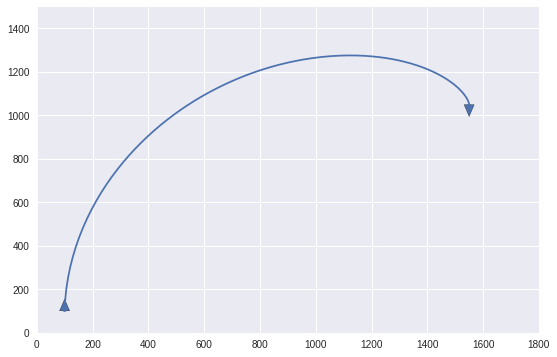

In [0]:
# simulated trajectoriies
init_state = np.array([100, 100, np.pi/2])
goal_state = np.array([1550, 1050, -np.pi/2])

traj = traj_generation(init_state,goal_state,mode=1)
traj = np.reshape(traj, [len(traj), 3])

plt.figure(figsize = (9,6))
plt.xlim((0,1800))
plt.ylim((0,1500))
plt.plot(traj[:,0],traj[:,1])
plt.arrow(init_state[0],init_state[1],np.cos(init_state[2]),np.sin(init_state[2]),width = 12)
plt.arrow(goal_state[0],goal_state[1],np.cos(goal_state[2]),np.sin(goal_state[2]),width = 12)
plt.grid(True)

**2(c). Translate the map of your environment (with obstacles) into C-space, and create a visualization of this map
with initial and goal states indicated.**

To represent workspace obstacles in C-space, we need to find the set of points that are not legal configurations.

For simplicity, here we considered the robot to be a circle of diameter 115mm as mentioned in problem statement.

In [0]:
def  operation_space(init_state, goal_state, obs_list):
    """
    Create a map includes all obstacles and initial, goal states of the robot in Ospace.
    Input:
    init_state = (x,y,theta)
    goal_state = (x,y,theta)
    obs_list = (x,y,width,height)
    """
    fig = plt.figure(figsize = (9,6))
    ax = fig.add_subplot(1,1,1)
    plt.xlim((0,1800))
    plt.ylim((0,1200))
    plt.grid(True)
    plt.title("Operation Space", fontsize =20)
    plt.arrow(init_state[0], init_state[1], np.cos(init_state[2]),
          np.sin(init_state[2]), color='g', width=12)
    plt.arrow(goal_state[0], goal_state[1], np.cos(goal_state[2]),
              np.sin(goal_state[2]), color='r', width=12)
    
    for obs in obs_list:
        obstacle = plt.Rectangle(obs[0:2], obs[2], obs[3])
        ax.add_patch(obstacle)
    return ax
  
  
def config_space(init_state, goal_state, obs_list):
    """
    Create a map includes all obstacles in Cspace
    """
    epsilon = (np.sqrt(2)-1)*R/(2*np.sqrt(2))

    ax = operation_space(init_state, goal_state, obs_list) 
    plt.title("Configuration Space", fontsize =20)
    p={}
    c_obs_list = {}
    for x in obs_list:
        #Create patch for obstacles 
        r1 = plt.Rectangle((x[0]-R/2,x[1]),R/2,x[3])
        r2 = plt.Rectangle((x[0]+x[2],x[1]),R/2,x[3])
        r3 = plt.Rectangle((x[0],x[1]+x[3]),x[2],R/2)
        r4 = plt.Rectangle((x[0],x[1]-R/2),x[2],R/2)
        
        c1 = plt.Circle((x[0],x[1]),R/2)
        c2 = plt.Circle((x[0]+x[2],x[1]),R/2)
        c3 = plt.Circle((x[0]+x[2],x[1]+x[3]),R/2)
        c4 = plt.Circle((x[0],x[1]+x[3]),R/2)
        
        patch_list = [r1,r2,r3,r4,c1,c2,c3,c4]
        for i in patch_list:
          ax.add_patch(i)
          
        # Create Chall vertcies  
        theta_sample = np.linspace(-np.pi, np.pi, 100)
        points = []
        for theta in theta_sample:
            A = [[x[0], x[1], theta], [x[0]+x[2], x[1], theta],
                 [x[0], x[1]+x[3], theta], [x[0]+x[2], x[1]+x[3], theta]]
            for a in A:
                v1 = [a[0]+70*cos(theta)+42.5*cos(theta-np.pi/2),
                            a[1]+70*sin(theta)+42.5*sin(theta-np.pi/2), theta]
                v2 = [a[0]+70*cos(theta)+42.5*cos(theta+np.pi/2),
                            a[1]+70*sin(theta)+42.5*sin(theta+np.pi/2), theta]
                v3 = [a[0]+10*cos(theta+np.pi)+42.5*cos(theta-np.pi/2),
                            a[1]+10*sin(theta+np.pi)+42.5*sin(theta-np.pi/2), theta]
                v4 = [a[0]+10*cos(theta+np.pi)+42.5*cos(theta+np.pi/2),
                            a[1]+10*sin(theta+np.pi)+42.5*sin(theta+np.pi/2), theta]
                points.append(a)
                points.append(v1)
                points.append(v2)
                points.append(v3)
                points.append(v4)

        points = np.array(points)
        hull= ConvexHull(points)
        c_obs_list[x] = hull          
               
    return ax, c_obs_list

Simulate a parking lot with 2 exits.

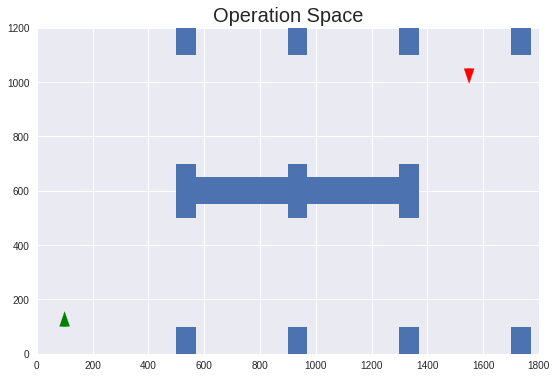

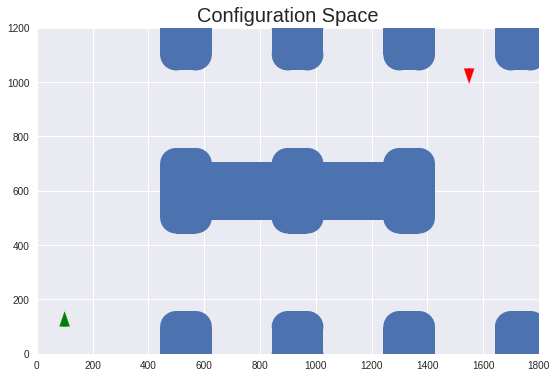

In [0]:
obs_list=[
    (570, 550, 800, 100),
    (500, 500, 70, 200),
    
    (500, 0, 70, 100),
    (900, 0, 70, 100),
    (1300, 0, 70, 100),
    (1700, 0, 70, 100),

    (900, 500, 70, 50),
    (1300, 500, 70, 50),
    (900, 650, 70, 50),
    (1300, 650, 70, 50),
    
    (500, 1100, 70, 100),
    (900, 1100, 70, 100),
    (1300, 1100, 70, 100),
    (1700, 1100, 70, 100)]

ax = operation_space(init_state, goal_state, obs_list)
x, c_obs_list = config_space(init_state, goal_state, obs_list)

**2(d). Given this C-space map and an arbitrary robot trajectory, determine whether this trajectory is collision free.**

Check whether every trajectory point is outside the convex hull created previously.

In [0]:
def collision_check(traj, c_obs_list):
  """
  Check if the trajectory collide with the obstacles.
  Inputs:
  traj = The trajectory of the robot
  c_obs_list = The boundary of the obstacles.
  
  Output:
  boolean = [True]: no collision
            [False]: there is collision
  """
  
  collision_free = True
  
  for point in traj:
    for ob in c_obs_list.keys():
      o_hull = c_obs_list[ob]      
      r_hull = ConvexHull(np.concatenate((o_hull.points, [point])))
      
      if np.array_equal(r_hull.vertices, o_hull.vertices):
          collision_free = False      
  return collision_free

**2(e). Implement an RRT planner on this map to generate a trajectory from a specified initial state to the desired
goal state. Visualize the evolution of the RRT.**

An RRT grows a tree rooted at the starting configuration by using random samples from the search space. As each sample is drawn, a connection is attempted between it and the nearest state in the tree. If the connection is feasible (passes entirely through free space and obeys any constraints), this results in the addition of the new state to the tree. With uniform sampling of the search space, the probability of expanding an existing state is proportional to the size of its Voronoi region. As the largest Voronoi regions belong to the states on the frontier of the search, this means that the tree preferentially expands towards large unsearched areas.

In [0]:
def rrt(initial_state, goal_state, boundary):
    """
    Rapidly - exploring random tree
    Input:
    Initial State [x, y, heading]
    Goal State [x, y, heading]
    Boundary of the field
    
    Output:
    path = list of states forms the path
    traj = trajectory
    """
    start_node = node(initial_state)
    end_node = node(goal_state)
    ax = operation_space(initial_state, goal_state, obs_list)

    node_list = [start_node]
    step = 0
    goal_arrived = False
    np.random.seed(10)
    eps = 150
    while True:
        # Random Sampling
        random_point = np.zeros(3)     
        for i in range(3):
            random_point[i] = np.random.uniform(boundary[i][0], boundary[i][1])
        #print(random_point)    
        # Find nearest node
        nearestNode, min_index = find_nearest_node(node_list, random_point)
        # Expand tree
        traj_temp = traj_generation(nearestNode.state.copy(), random_point, mode=0)
        # Check for collision
        if collision_check(traj_temp, c_obs_list):
            newNode = node(traj_temp[-1])
            newNode.parent = min_index
            node_list.append(newNode)  
        # Check goal
        close_goal = np.linalg.norm(goal_state - node_list[-1].state.copy(), ord = 2)
        if close_goal < eps:
            goal_arrived = True
            print("Goal!")            
            break
            
    for n in node_list:
            if n.parent is not None:
                plt.plot([n.state[0],node_list[n.parent].state[0]],
                        [n.state[1],node_list[n.parent].state[1]],'-g')        
            
    path = [goal_state]
    lastIndex = len(node_list) - 1
    while node_list[lastIndex].parent is not None:
        node_t = node_list[lastIndex]
        path.append(node_t.state)
        lastIndex = node_t.parent
    path.append(initial_state)
    
    # Generate the trajectory
    traj = []
    i = len(path) - 1
    while i >= 1:
        traj_temp = traj_generation(path[i], path[i-1], mode=1)
        traj = traj + traj_temp
        i = i - 1
    return traj, path
  
  
def draw_robot(traj):
    """
    Draw every state of robot along the path
    """
    start = traj[0]
    end = traj[-1]
    ax = operation_space(start, end, obs_list)

    for pnt in traj:
        theta = pnt[2]
        c = plt.Circle((pnt[0],pnt[1]),R/2,fill=0,color = 'b')
        face = plt.arrow(pnt[0],pnt[1],np.cos(theta),np.sin(theta),width=10,color = 'k')
        ax.add_patch(c)
        ax.add_patch(face)
    plt.show()

Goal!


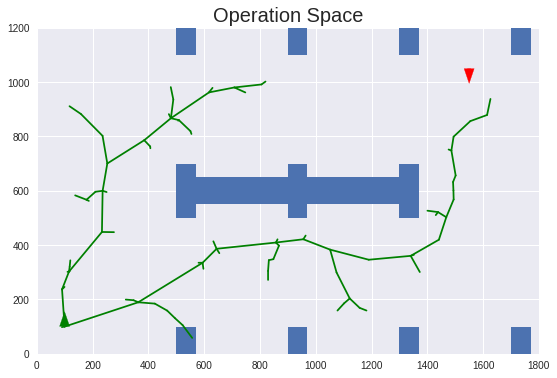

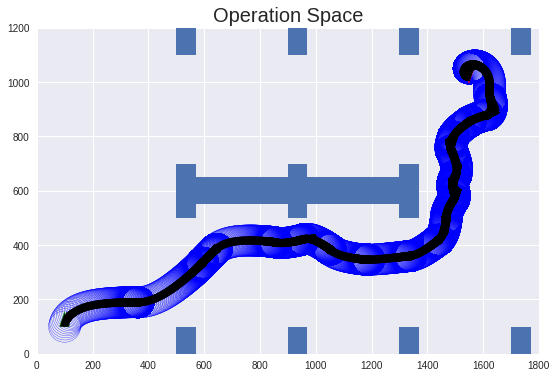

In [0]:
init_state = np.array([100, 100, np.pi/2])
goal_state = np.array([1550, 1050, -np.pi/2])
boundary = [(0, 1800), (0, 1200), (-np.pi, np.pi)]

traj, path = rrt(init_state, goal_state, boundary)
draw_robot(traj)

## Evaluation

** 3(a). Run some examples that demonstrate the performance (in terms of computational efficiency, trajectory efficiency,
and obstacle avoidance) of your planner as your robot tries to achieve various goals (such as head-in
parking and parallel parking between other such parked vehicles).**

Here I demonstrate different parking scenario (facing different direction and in different spot) using RRT algorithm.


Goal!


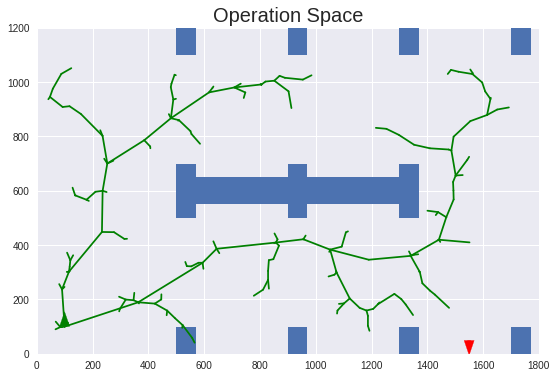

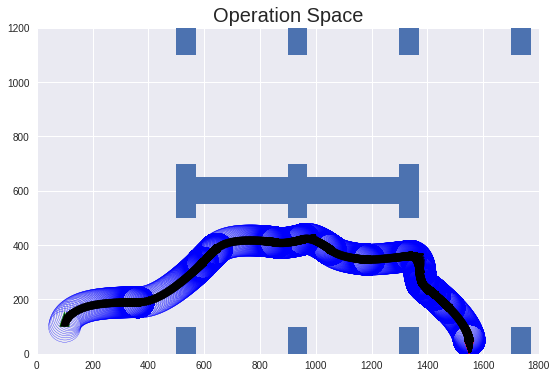

In [0]:
init_state = np.array([100, 100, np.pi/2])
goal_state = np.array([1550, 50, -np.pi/2])
traj, path = rrt(init_state, goal_state, boundary)
draw_robot(traj)

Goal!


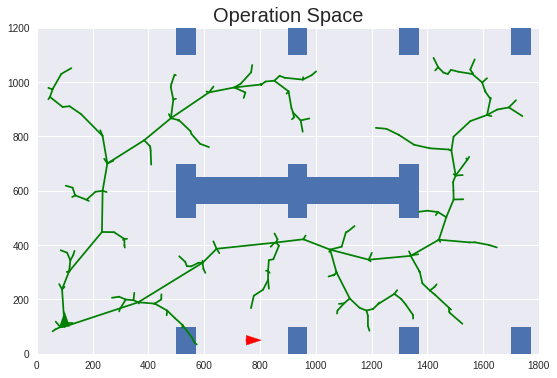

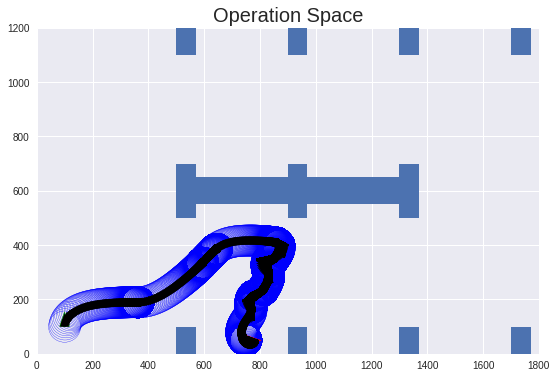

In [0]:
init_state = np.array([100, 100, np.pi/2])
goal_state = np.array([750, 50, 0])
traj, path = rrt(init_state, goal_state, boundary)
draw_robot(traj)

**3(b). How much relative computational cost is associated with the various operations of the RRT planner?**

The computational cost for RRT is high because of the random sampling, the computational cost grow exponentially with the expansion of area. The part cost the most computation is the tree expanding. To improve the speed, we can start the search from both the beginning and the goal, also instead random sampling, we may use guided sampling.

**3(c). Qualitatively describe some conclusions about the effectiveness of your planner for potential tasks your robot
may encounter. How might you improve it?**

The planner is sufficient to be employed in the robot navigation. Different parking scenario works very well in this case. However, the computational speed is not optimal. The path is not smooth neither optima. To improve the computational efficiency and get a more optimal solution, we need to have a better understanding of the environment. Then we are able to look into the area which are more likely to generate trajectories instead of random sampling. For example, instead of a simple map with obstacles, if we are able to feed a vector field map to the RRT and force it to sample those areas along the vector field, it may generate a better results.